In [46]:
import requests
from bs4 import BeautifulSoup

def create_table(link):
    url = link
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all tables with class 'wikitable'
    rallies_tables = soup.find_all('table', class_='wikitable')

    result = []
    date = " "
    for pope_table in rallies_tables:
        if pope_table:
            rows = pope_table.find_all('tr')
            rowspan_map = {}  # Map to handle rowspan data
            
            for row_idx, row in enumerate(rows):
                if row_idx == 0:  # Skip header row
                    continue
                
                # Initialize cells for this row
                cells = []
                
                # Process <th> as a special case for the date
                th = row.find("th")
                if th:
                    date = th.text.strip()
                cells.append(date)
                
                # Process all <td> tags
                tds = row.find_all("td")
                col_idx = 0  # Track current column index
                for td in tds:
                    # Skip columns occupied by `rowspan` data
                    while col_idx in rowspan_map and rowspan_map[col_idx]:
                        cells.append(rowspan_map[col_idx].pop(0))
                        col_idx += 1
                    
                    # Add the current cell's text
                    text = td.text.strip()
                    cells.append(text)
                    
                    # Handle `rowspan` for this cell
                    rowspan = int(td.get("rowspan", 1))
                    if rowspan > 1:
                        if col_idx not in rowspan_map:
                            rowspan_map[col_idx] = []
                        rowspan_map[col_idx].extend([text] * (rowspan - 1))
                    
                    col_idx += 1
                
                # Fill remaining columns with `rowspan_map` data
                while col_idx in rowspan_map and rowspan_map[col_idx]:
                    cells.append(rowspan_map[col_idx].pop(0))
                    col_idx += 1
                
                # Add the processed row to the result
                result.append(cells)
    return result



             State  Value
0          Arizona      6
1       California      1
2         Colorado      1
3          Florida      2
4          Georgia      8
5             Iowa      3
6         Michigan     13
7        Minnesota      1
8          Montana      1
9           Nevada      8
10   New Hampshire     11
11      New Jersey      1
12      New Mexico      1
13        New York      3
14  North Carolina     15
15            Ohio      1
16    Pennsylvania     20
17  South Carolina      5
18    South Dakota      1
19           Texas      1
20        Virginia      3
21       Wisconsin     11


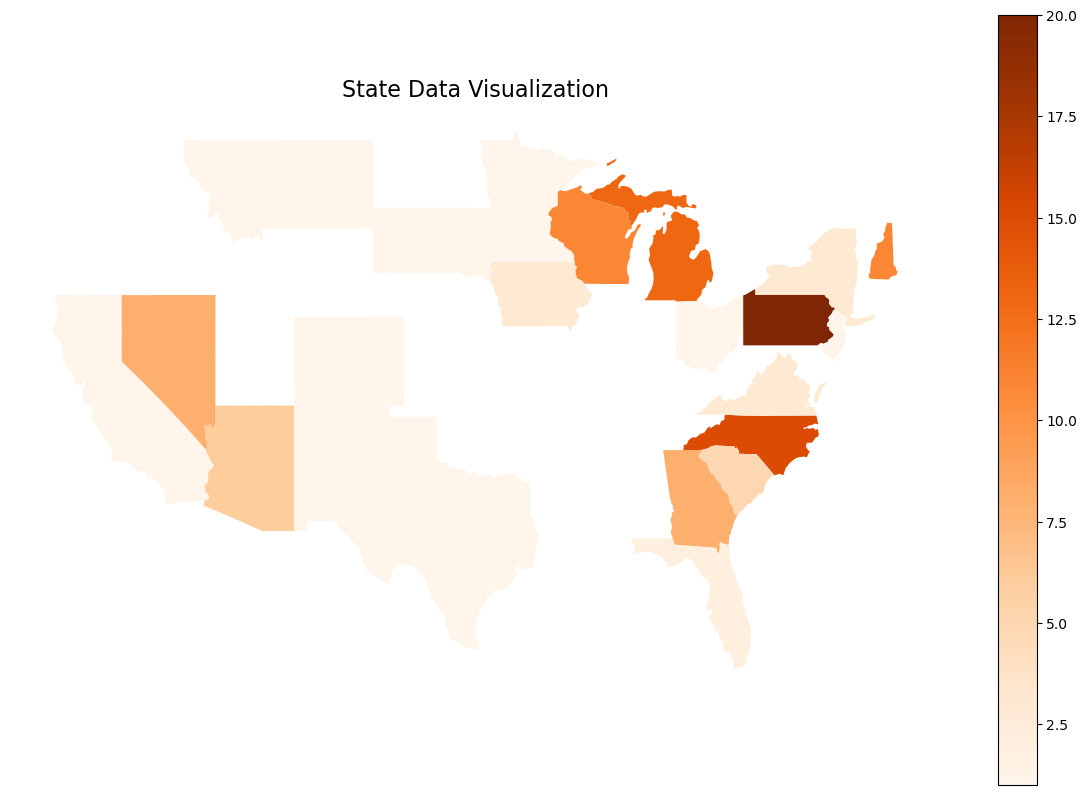

             State  Value
0          Alabama      3
1          Arizona      8
2         Arkansas      2
3       California      8
4         Colorado     10
5      Connecticut      4
6         Delaware      1
7          Florida     33
8          Georgia      5
9         Illinois      2
10         Indiana      8
11            Iowa     36
12          Kansas      1
13        Kentucky      1
14       Louisiana      2
15           Maine      5
16        Maryland      2
17   Massachusetts      4
18        Michigan      9
19       Minnesota      1
20     Mississippi      3
21        Missouri      2
22         Montana      1
23        Nebraska      1
24          Nevada     11
25   New Hampshire     25
26      New Mexico      2
27        New York      9
28  North Carolina     21
29            Ohio     20
30        Oklahoma      3
31          Oregon      1
32    Pennsylvania     19
33    Rhode Island      1
34  South Carolina     21
35       Tennessee      3
36           Texas      6
37          

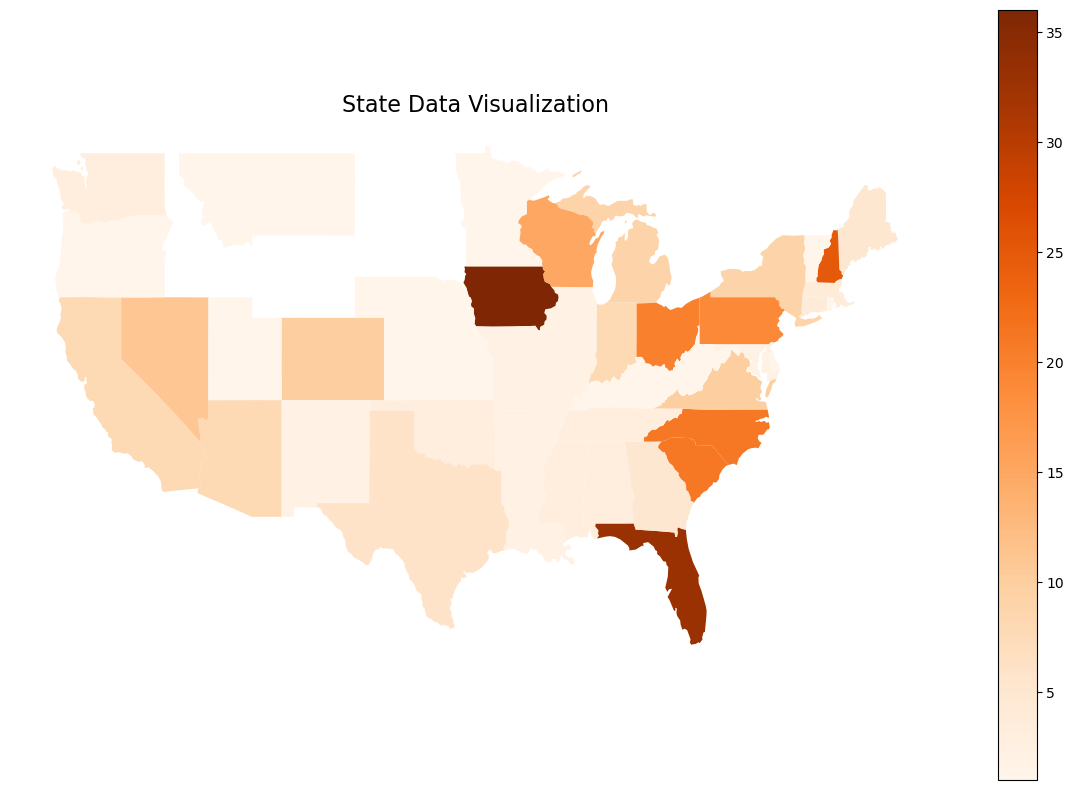

In [47]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
state_code_to_name = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming",
}

def create_map(result, num_row):
    mapa = {}
    for row in result:
        subject = row[num_row]  # Assuming 'row[2]' contains the subject
        if subject in mapa:  # Check if subject is already in 'mapa'
            mapa[subject] += 1
        else:
            mapa[subject] = 1
    mapa2 = {}
    for state_code, state_name in state_code_to_name.items():
        if state_code in mapa: 
            mapa2[state_name] = mapa[state_code]
    # Convert the map to a DataFrame
    df = pd.DataFrame(list(mapa2.items()), columns=["State", "Value"])

    # Display the DataFrame
    print(df)

    # Load a GeoJSON file with US state boundaries
    # You may need to download it, e.g., https://eric.clst.org/tech/usgeojson/
    us_states = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

    # Merge the GeoDataFrame with your data
    merged = us_states.merge(df, how="left", left_on="name", right_on="State")

    # Plot the map, coloring states by the 'Value' column
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    merged.plot(column="Value", cmap="Oranges", legend=True, ax=ax)

    # Add title and remove axis
    ax.set_title("State Data Visualization", fontsize=16)
    ax.axis("off")

    plt.show()
create_map(create_table('https://en.wikipedia.org/wiki/List_of_rallies_for_the_2024_Donald_Trump_presidential_campaign'), 2)
create_map(create_table('https://en.wikipedia.org/wiki/List_of_rallies_for_the_2016_Donald_Trump_presidential_campaign'), 3)